# Node
# State
# Tool

# ToolNode:
A Tool Node is just a special kind of node whose mail job is to run a tool
It connect the tools output back into the state, so other nodes can use that information

# StateGraph

- Is a class in LangGraph used to build and compile the graph structure
- It manages the nodes, edges and, the overall state, ensuring that the workflow operations in a unified way 
  and, that data flows correctly between components

# Runnable
- A runnable in langraph is a standardizexd executable component that performs a specific task within an AI workflow
- It servers as a fundamental building block, allowing for us to create modular systems

# Messages:
- Human Message: Rrepresents input from a user. 
- System Message: Used to provide instructions or context to the model
- Function Message: Represents the result of a functional call
- AI Message: Represents responses generated by AI Model
- Tool Message: Similar to functional message, but specific to tool usage



# LangGraph Learning and Testing

This notebook is for learning and experimenting with LangGraph. Let's start by testing our setup and basic imports.

In [ ]:
# Test basic imports
import sys
print(f"Python version: {sys.version}")
print(f"Python executable: {sys.executable}")

# Test LangGraph imports
try:
    import langgraph
    print(f"✅ LangGraph version: Installed successfully")
except ImportError as e:
    print(f"❌ LangGraph import failed: {e}")

try:
    import langchain
    print(f"✅ LangChain version: {langchain.__version__}")
except ImportError as e:
    print(f"❌ LangChain import failed: {e}")

try:
    from langchain_openai import ChatOpenAI
    print("✅ LangChain OpenAI imported successfully")
except ImportError as e:
    print(f"❌ LangChain OpenAI import failed: {e}")

In [ ]:
# Type - 1: LangGraph Hello World Graph  

from typing import Dict, TypedDict
from langgraph.graph import StateGraph # Framework that helps design and manage the flow of the tasks in our application using a graph structure.

class AgentState(TypedDict):
    message: str

def greeting_agent(state: AgentState) -> AgentState:
    state["message"] = "Hello, LangGraph!"
    return state

graph = StateGraph(AgentState)
graph.add_node("greeter", greeting_agent)

# Set the entry point for the graph
graph.set_entry_point("greeter")
graph.set_finish_point("greeter")

app = graph.compile()

# from IPython.display import display, Image
# display(Image(app.get_graph().draw_mermaid_png()))

result = app.invoke({"message": "Ajay"})
result["message"]  # Expected Output: "Hello, LangGraph!"





In [ ]:
# Type - 1: Multiple Inputs  
# Import lesson: All the values in the state needs to initalized in the AgentState TypedDict
from typing import Dict, List

class AgentState(TypedDict):
    values: List[int]
    final_str: str
    multiplier: int
    result: int

def processor_add(state: AgentState) -> AgentState:
    state["result"] = sum(state["values"])
    return state

def processor_multiply(state: AgentState) -> AgentState:
    state["result"] = state["result"] * state["multiplier"]
    return state

def processor_to_string(state: AgentState) -> AgentState:
    state["final_str"] = f"The final result is: {state['result']}"
    return state

graph = StateGraph(AgentState)
graph.add_node("add", processor_add)
graph.add_node("multiply", processor_multiply)
graph.add_node("to_string", processor_to_string)

# Define the flow of the graph
graph.add_edge("add", "multiply")
graph.add_edge("multiply", "to_string")

# Set entry and finish points
graph.set_entry_point("add")
graph.set_finish_point("to_string")

app = graph.compile()

test = app.invoke({"values": [1, 2, 3], "multiplier": 10, "final_str": ""})
test["final_str"]  # Expected Output: "The final result is: 60"


In [ ]:
# Type - 3: Conditional Graphs (Fixed - Sequential Operations)

from langgraph.graph import StateGraph, START, END

class AgentState(TypedDict):
    number1: int
    number2: int
    operation: str
    number3: int
    number4: int
    operation2: str
    final_result: int
    final_result2: int

def add_node_1(state: AgentState) -> AgentState:
    state["final_result"] = state["number1"] + state["number2"]
    return state

def subtract_node_1(state: AgentState) -> AgentState:
    state["final_result"] = state["number1"] - state["number2"]
    return state

def add_node_2(state: AgentState) -> AgentState:
    state["final_result2"] = state["number3"] + state["number4"]
    return state

def subtract_node_2(state: AgentState) -> AgentState:
    state["final_result2"] = state["number3"] - state["number4"]
    return state

def decide_operation_1(state: AgentState) -> str:
    if state["operation"] == "+":
        return "add_edge_1"
    else:
        return "subtract_edge_1"

def decide_operation_2(state: AgentState) -> str:
    if state["operation2"] == "+":
        return "add_edge_2"
    else:
        return "subtract_edge_2"

# Create the graph
graph = StateGraph(AgentState)

# Add all nodes
graph.add_node("add_node_1", add_node_1)
graph.add_node("subtract_node_1", subtract_node_1)
graph.add_node("router_1", lambda state: state)  # Placeholder for first router
graph.add_node("add_node_2", add_node_2)
graph.add_node("subtract_node_2", subtract_node_2)
graph.add_node("router_2", lambda state: state)  # Placeholder for second router

# Sequential flow: START -> Operation 1 -> Operation 2 -> END
graph.add_edge(START, "router_1")

# First operation conditional routing
graph.add_conditional_edges(
    "router_1",
    decide_operation_1,
    {
        "add_edge_1": "add_node_1", 
        "subtract_edge_1": "subtract_node_1"
    }
)

# Connect first operations to second router
graph.add_edge("add_node_1", "router_2")
graph.add_edge("subtract_node_1", "router_2")

# Second operation conditional routing
graph.add_conditional_edges(
    "router_2",
    decide_operation_2,
    {
        "add_edge_2": "add_node_2", 
        "subtract_edge_2": "subtract_node_2"
    }
)

# Connect second operations to END
graph.add_edge("add_node_2", END)
graph.add_edge("subtract_node_2", END)

app = graph.compile()
from IPython.display import display, Image
display(Image(app.get_graph().draw_mermaid_png()))

# Test the fixed graph
result1 = app.invoke({
    "number1": 10,
    "number2": 5,
    "operation": "+",
    "number3": 20,
    "number4": 8,
    "operation2": "-",
    "final_result": 0,  # Initialize these fields
    "final_result2": 0
})

print(f"Operation 1: {result1['number1']} {result1['operation']} {result1['number2']} = {result1['final_result']}")
print(f"Operation 2: {result1['number3']} {result1['operation2']} {result1['number4']} = {result1['final_result2']}")
print(f"Final Result 1: {result1['final_result']}")  # Expected Output: 15
print(f"Final Result 2: {result1['final_result2']}")  # Expected Output: 12

In [ ]:
# Type - 4: Looping Graphs (Fixed - Sequential Operations)

from langgraph.graph import StateGraph, START, END
class AgentState(TypedDict):
    count: int
    limit: int
    result: int
    string_result: str

def increment_node(state: AgentState) -> AgentState:
    state["count"] += 1
    state["result"] += state["count"]
    print(f"Current Count: {state['count']}, Current Result: {state['result']}")
    return state

def check_limit(state: AgentState) -> AgentState:
    if state["count"] < state["limit"]:
        return "increment_edge"
    else:
        return "end_edge"

def to_string_node(state: AgentState) -> AgentState:
    state["string_result"] = f"The final count is: {state['count']} and the result is: {state['result']}"
    return state

# Create the graph
graph = StateGraph(AgentState)
graph.add_node("increment", increment_node)
graph.add_node("check_limit", lambda state: state)  # Placeholder for the router
graph.add_node("to_string", to_string_node)

# Define the flow of the graph
graph.add_edge(START, "increment")
graph.add_edge("increment", "check_limit")
graph.add_conditional_edges(
    "check_limit",
    check_limit,
    {
        "increment_edge": "increment",
        "end_edge": "to_string"
    }
)
graph.add_edge("to_string", END)

app = graph.compile()
from IPython.display import display, Image
display(Image(app.get_graph().draw_mermaid_png()))

# Test the looping graph
result2 = app.invoke({
    "count": 0,
    "limit": 5,
    "result": 0,
    "string_result": ""
})
print(result2["string_result"])  # Expected Output: "The final count is: 5 and the result is: 15"




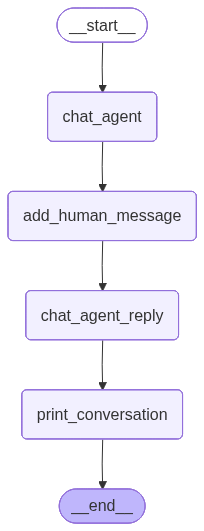

[HumanMessage(content='Hello chatgpt! my name is Ajay.', additional_kwargs={}, response_metadata={}), AIMessage(content='Hello Ajay! How can I assist you today?', additional_kwargs={}, response_metadata={}), HumanMessage(content="What's 2X2 ?. Just give me the result number. No extra strings", additional_kwargs={}, response_metadata={})]
[HumanMessage(content='Hello chatgpt! my name is Ajay.', additional_kwargs={}, response_metadata={}), AIMessage(content='Hello Ajay! How can I assist you today?', additional_kwargs={}, response_metadata={}), HumanMessage(content="What's 2X2 ?. Just give me the result number. No extra strings", additional_kwargs={}, response_metadata={}), AIMessage(content='4', additional_kwargs={}, response_metadata={})]
human: Hello chatgpt! my name is Ajay.
ai: Hello Ajay! How can I assist you today?
human: What's 2X2 ?. Just give me the result number. No extra strings
ai: 4
Conversation history saved to conversation_history.txt


In [37]:
# Type - II ChatBot agent which stores conversation history and uses it to generate context-aware responses.

from langgraph.graph import StateGraph, START, END
from typing import TypedDict, List, Union
from langchain_core.messages import HumanMessage, AIMessage
from langchain_openai import ChatOpenAI
from dotenv import load_dotenv



load_dotenv()

class AgentState(TypedDict):
    messages: List[Union[HumanMessage, AIMessage]]

history = []
llm = ChatOpenAI(model="gpt-4o")

def chat_agent(state: AgentState) -> AgentState:
    response = llm.invoke(state["messages"])
    state["messages"].append(AIMessage(content=response.content))
    return state

def add_human_message(state: AgentState) -> AgentState:
    user_input = "What's 2X2 ?. Just give me the result number. No extra strings"
    state["messages"].append(HumanMessage(content=user_input))
    return state

def chat_agent_reply(state: AgentState) -> AgentState:
    response = llm.invoke(state["messages"])
    print(state["messages"])
    state["messages"].append(AIMessage(content=response.content))
    print(state["messages"])
    return state

def print_conversation(state: AgentState) -> AgentState:
    for msg in state["messages"]:
        print(f"{msg.type}: {msg.content}")
    return state

graph = StateGraph(AgentState)
graph.add_node("add_human_message", add_human_message)
graph.add_node("chat_agent", chat_agent)
graph.add_node("chat_agent_reply", chat_agent_reply)
graph.add_node("print_conversation", print_conversation)

graph.add_edge(START, "chat_agent")
graph.add_edge("chat_agent", "add_human_message")
graph.add_edge("add_human_message", "chat_agent_reply")
graph.add_edge("chat_agent_reply", "print_conversation")
graph.add_edge("print_conversation", END)

app = graph.compile()
from IPython.display import display, Image
display(Image(app.get_graph().draw_mermaid_png()))

# Test the chatbot agent
initial_state: AgentState = {
    "messages": [HumanMessage(content="Hello chatgpt! my name is Ajay.")],
}
final_state = app.invoke(initial_state)

with open("conversation_history.txt", "w") as f:
    f.write("Conversation History:\n\n")
    for msg in final_state["messages"]:
        if isinstance(msg, HumanMessage):
            f.write(f"Human: {msg.content}\n")
        elif isinstance(msg, AIMessage):
            f.write(f"AI: {msg.content}\n\n")
    f.write("End of Conversation\n")
print("Conversation history saved to conversation_history.txt")



In [ ]:
from typing import TypedDict, List, Union
from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage, AIMessage
from langgraph.graph import StateGraph, START, END
from dotenv import load_dotenv


load_dotenv()

class AgentState(TypedDict):
    messages : List[Union[HumanMessage, AIMessage]]

llm = ChatOpenAI(model="gpt-4o")

def process(state: AgentState) -> AgentState:
    """This node will solve the request you input"""
    response = llm.invoke(state["messages"])
    state["messages"].append(AIMessage(content=response.content))
    print("AI:", response.content)
    return state





graph = StateGraph(AgentState)
graph.add_node("process",process)
graph.add_edge(START, "process")
graph.add_edge("process", END)

agent = graph.compile()

user_input = input("Enter your message: ")

conversation_history = []
while user_input.lower() not in ["exit", "quit"]:
    conversation_history.append(HumanMessage(content=user_input))
    result = agent.invoke({"messages": conversation_history})
    print(result)
    conversation_history = result["messages"]
    user_input = input("Enter your message: ")
    print(user_input)

In [ ]:
# Test the workflow execution
initial_state = {
    "counter": 5,
    "message": "Starting with counter = 5"
}

print("Initial state:")
print(f"Counter: {initial_state['counter']}")
print(f"Message: {initial_state['message']}")
print("\n" + "="*50 + "\n")

# Run the workflow
final_state = app.invoke(initial_state)

print("Final state:")
print(f"Counter: {final_state['counter']}")
print(f"Message: {final_state['message']}")
print("\n✅ Workflow executed successfully!")

## Next Steps

Now that we've verified our LangGraph setup is working, we can:

1. **Create more complex workflows** with conditional edges
2. **Integrate with LLMs** using LangChain models
3. **Add memory and persistence** with checkpoints
4. **Build agent-based systems** with tool calling
5. **Create multi-agent workflows** with different roles

The environment is ready for LangGraph learning and experimentation!

In [ ]:
# Environment information
import os
import subprocess

print("📁 Project Directory:", os.getcwd())
print("🐍 Virtual Environment:", os.environ.get('VIRTUAL_ENV', 'Not activated (using UV)'))
print("📦 UV Project:")

# Check if we're in a UV project
if os.path.exists('pyproject.toml'):
    with open('pyproject.toml', 'r') as f:
        content = f.read()
        if '[project]' in content:
            lines = content.split('\n')
            for line in lines:
                if 'name = ' in line:
                    print(f"   Project Name: {line.split('=')[1].strip().strip('"')}")
                elif 'version = ' in line:
                    print(f"   Version: {line.split('=')[1].strip().strip('"')}")
                    break